кол-во чеков = кол-во походов в магазин

crazy-акция - по всем группам товаров

In [239]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn import linear_model, metrics, preprocessing

import azureml.core
from azureml.core import Dataset
from azureml.core.authentication import InteractiveLoginAuthentication
from azureml.core import Experiment, Workspace

In [240]:
# Log In to Azure ML Workspace
interactive_auth = InteractiveLoginAuthentication(tenant_id="76f90eb1-fb9a-4446-9875-4d323d6455ad")

# Initialise workspace
ws = Workspace.from_config(auth=interactive_auth)

# Data import 
aml_dataset = Dataset.get_by_name(ws, 'train_ds', version='latest')
data = aml_dataset.to_pandas_dataframe()
data.set_index('CardHolder', inplace=True)

# Save it to the further opeartions
original_columns = data.columns

/anaconda/envs/py37_default/lib/python3.7/site-packages/azureml/dataprep/api/dataflow.py:722: UserWarning: Your pandas and pyarrow versions are incompatible. Please install pyarrow>=0.12.0 for improved performance of to_pandas_dataframe. You can ensure the correct version is installed by running: pip install pyarrow>=0.12.0 --upgrade
  warnings.warn('Your pandas and pyarrow versions are incompatible. '


# 1. Outliers
Первоначальное избавление от выбросов поможет в дальнейшнем грамотнее исправить ошибки в данных

In [241]:
# Any group number is in diaposon from 20 to 79
all_groups = [i for i in range(20, 80)]

# This function returns columns from 'columns' list, which are met in columns of "data"
def get_columns_list(data, columns):
    return data.columns[data.columns.isin(columns)]

Соберем интересующие нас признаки: некоторые уже есть в датасете, некоторые придется собирать.

In [242]:
# Name of a feature : (columns to collect from, method)
# methods : mean, max, min, sum
collect_features = {
    'cheque_count_12m_sum'             : (get_columns_list(data, ['cheque_count_12m_g{}'.format(i) for i in all_groups]), 'sum'),
    'children'                         : (['children'], 'max'),
    'crazy_purchases_cheque_count_12m' : (['crazy_purchases_cheque_count_12m'], 'max'),
    'k_var_disc_share_6m_max'          : (get_columns_list(data, ['k_var_disc_share_6m_g{}'.format(i) for i in all_groups]), 'max'),
    'k_var_sku_price_6m_max'           : (get_columns_list(data, ['k_var_sku_price_6m_g{}'.format(i) for i in all_groups]), 'max'),
    'sale_sum_12m_sum'                  : (get_columns_list(data, ['sale_sum_6m_g{}'.format(i) for i in all_groups]), 'sum'),
}

# Add collections
for key in collect_features.keys():
    method = collect_features[key][1]
    
    if method == 'mean':
        data.loc[:, key] = data[collect_features[key][0]].mean(axis=1)
    elif method == 'sum':
        data.loc[:, key] = data[collect_features[key][0]].sum(axis=1)
    elif method == 'max':
        data.loc[:, key] = data[collect_features[key][0]].max(axis=1)
    elif method == 'min':
        data.loc[:, key] = data[collect_features[key][0]].min(axis=1)
        
# Additional observations
add_features = ['cheques_per_child', 'sales_per_child']
data['cheques_per_child'] = data['cheque_count_12m_sum'] / (data['children'].fillna(0) + 1)
data['sales_per_child'] = data['sale_sum_12m_sum' ] / (data['children'].fillna(0) + 1)

По собранным признакам посмотрим на значения-выбросы, которые опредялетются по разным пропорциям (whis) относительно IQR. Полученные записи разделим на записи из тестовой и контрольной групп и их разделим по участию в акции. Посмотрим на пропорции.

Column cheque_count_12m_sum
                     Type   whis1  whis1.5   whis2  whis2.5
0     w/o outliers_test_0  418943   432047  440669   446363
1     w/o outliers_test_1   37684    41853   45024    47506
2  w/o outliers_control_0  140461   144816  147624   149541
3  w/o outliers_control_1   11639    12905   13940    14704
4         outliers_test_0   40136    27032   18410    12716
5         outliers_test_1   19129    14960   11789     9307
6      outliers_control_0   13121     8766    5958     4041
7      outliers_control_1    5916     4650    3615     2851


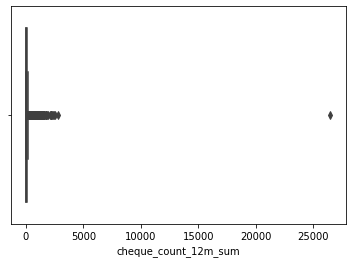

Column children
                     Type   whis1  whis1.5   whis2  whis2.5
0     w/o outliers_test_0  436922   436922  453304   453304
1     w/o outliers_test_1   53728    53728   55595    55595
2  w/o outliers_control_0  146257   146257  151684   151684
3  w/o outliers_control_1   16604    16604   17185    17185
4         outliers_test_0   16817    16817     435      435
5         outliers_test_1    1930     1930      63       63
6      outliers_control_0    5592     5592     165      165
7      outliers_control_1     598      598      17       17


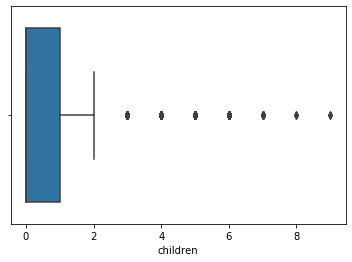

Column crazy_purchases_cheque_count_12m
                     Type   whis1  whis1.5   whis2  whis2.5
0     w/o outliers_test_0  420112   428149  438737   442364
1     w/o outliers_test_1   41166    43475   46811    48116
2  w/o outliers_control_0  141185   143750  147196   148333
3  w/o outliers_control_1   12970    13620   14654    15050
4         outliers_test_0   38967    30930   20342    16715
5         outliers_test_1   15647    13338   10002     8697
6      outliers_control_0   12397     9832    6386     5249
7      outliers_control_1    4585     3935    2901     2505


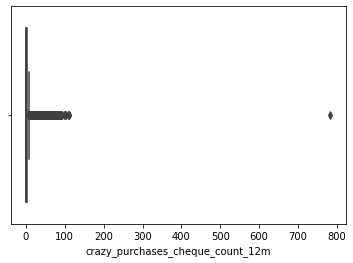

Column k_var_disc_share_6m_max
                     Type   whis1  whis1.5   whis2  whis2.5
0     w/o outliers_test_0  454970   455755  455989   456137
1     w/o outliers_test_1   56083    56391   56477    56552
2  w/o outliers_control_0  152232   152503  152582   152618
3  w/o outliers_control_1   17343    17423   17457    17480
4         outliers_test_0    1373      588     354      206
5         outliers_test_1     692      384     298      223
6      outliers_control_0     477      206     127       91
7      outliers_control_1     194      114      80       57


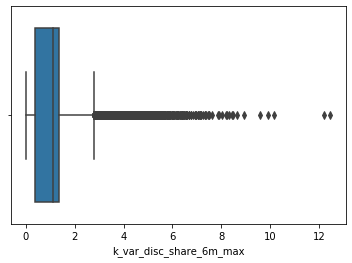

Column k_var_sku_price_6m_max
                     Type   whis1  whis1.5   whis2  whis2.5
0     w/o outliers_test_0  451231   455562  456428   456621
1     w/o outliers_test_1   54360    56138   56613    56732
2  w/o outliers_control_0  150977   152395  152719   152785
3  w/o outliers_control_1   16797    17356   17487    17523
4         outliers_test_0    5444     1113     247       54
5         outliers_test_1    2421      643     168       49
6      outliers_control_0    1831      413      89       23
7      outliers_control_1     742      183      52       16


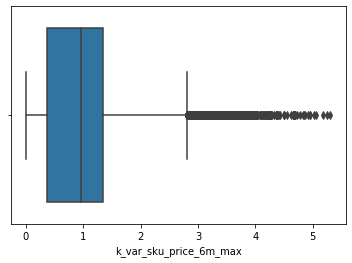

Column sale_sum_12m_sum
                     Type   whis1  whis1.5   whis2  whis2.5
0     w/o outliers_test_0  413420   426160  434636   440692
1     w/o outliers_test_1   37542    41194   44137    46519
2  w/o outliers_control_0  138707   142905  145788   147717
3  w/o outliers_control_1   11585    12724   13618    14312
4         outliers_test_0   45659    32919   24443    18387
5         outliers_test_1   19271    15619   12676    10294
6      outliers_control_0   14875    10677    7794     5865
7      outliers_control_1    5970     4831    3937     3243


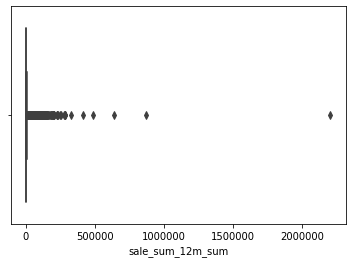

Column cheques_per_child
                     Type   whis1  whis1.5   whis2  whis2.5
0     w/o outliers_test_0  415150   427950  437007   442834
1     w/o outliers_test_1   37889    41595   44638    46970
2  w/o outliers_control_0  139265   143495  146430   148327
3  w/o outliers_control_1   11743    12843   13785    14465
4         outliers_test_0   43929    31129   22072    16245
5         outliers_test_1   18924    15218   12175     9843
6      outliers_control_0   14317    10087    7152     5255
7      outliers_control_1    5812     4712    3770     3090


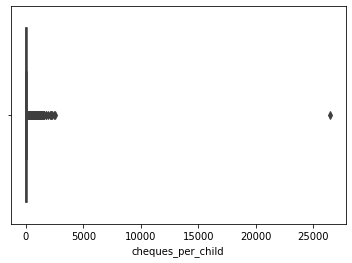

Column sales_per_child
                     Type   whis1  whis1.5   whis2  whis2.5
0     w/o outliers_test_0  411465   423935  432438   438565
1     w/o outliers_test_1   37904    41397   44039    46181
2  w/o outliers_control_0  137982   142124  144973   146918
3  w/o outliers_control_1   11710    12766   13605    14219
4         outliers_test_0   47614    35144   26641    20514
5         outliers_test_1   18909    15416   12774    10632
6      outliers_control_0   15600    11458    8609     6664
7      outliers_control_1    5845     4789    3950     3336


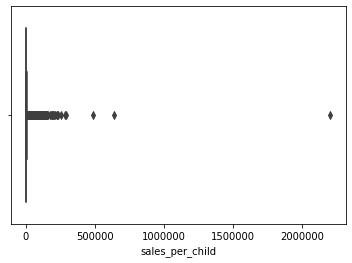

In [243]:
# Cycle by chosen features
for key in list(collect_features.keys()) + add_features:
    print('Column', key)
    
    # Table format
    dataframe = {'Type' : [i+j for i in ['w/o outliers', 'outliers'] for j in ['_test_0', '_test_1', '_control_0', '_control_1']]}
    for whis in [1, 1.5, 2, 2.5]:
        IQR = data[key].quantile(0.75) - data[key].quantile(0.25)
        
        # Separate data w/o outliers
        sample = data[data[key] <= data[key].quantile(0.75) + IQR * whis]
        
        # Separate groups
        sample_test = sample[sample['group'] == 'test']['response_att'].value_counts()
        sample_control = sample[sample['group'] == 'control']['response_att'].value_counts()
        
        dataframe['whis{}'.format(whis)] = [sample_test[0], sample_test[1], sample_control[0], sample_control[1]]
        
         # Separate data outliers
        sample = data[data[key] > data[key].quantile(0.75) + IQR * whis]
        
        # Separate groups
        sample_test = sample[sample['group'] == 'test']['response_att'].value_counts()
        sample_control = sample[sample['group'] == 'control']['response_att'].value_counts()
        
        dataframe['whis{}'.format(whis)] += [sample_test[0], sample_test[1], sample_control[0], sample_control[1]]
    
    print(pd.DataFrame(dataframe))
    sns.boxplot(data[key])
    plt.show()

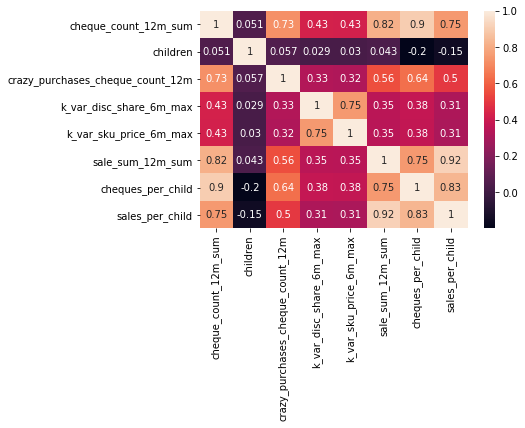

In [244]:
sns.heatmap(data[[key for key in list(collect_features.keys()) + add_features]].corr(), annot=True)
plt.show()

Проверка матрицы корреляции не выявила какой-то особенной связи.

Ни один из проверенных параметров не дал полезного результата: разделяя по выбросам, мы обнаружили, что соотношение людей в тестовой и контрольной группе примерно одно и то же. Отделим выбросы и попытаемся (по whis=1.5) и продолжим поиски. 

In [245]:
# Separation parameter
whis = 1.5

# Cycle by chosen features
for key in list(collect_features.keys()) + add_features:
    
    # Drop outliers
    IQR = data[key].quantile(0.75) - data[key].quantile(0.25)
    data = data[data[key] <= data[key].quantile(0.75) + IQR * whis]

# 2. Чистка данных
Решим проблему с NaN. Сначала посмотрим, сколько строк вообще не имеют ошибок

In [246]:
data.isna().any(axis=1).value_counts()

True     450780
False       190
dtype: int64

Таких строк очень мало, поэтому придётся как-то заполнять NaN. Если заполнять средними, то это слишком разрежено, поэтому будем заполнять для каждого индекса по-своему. Индекс - это определенные значения колон из "index_columns". Проблема в том, что и них встречаются NaN значения.

In [247]:
print("Чаще всего у покупателя",
      data['children'].value_counts().sort_values(ascending=False).index[0],
      "детей")

Чаще всего у покупателя 0.0 детей


In [248]:
index_columns = ['gender', 'main_format', 'children']

# Let's fill NaN in "index_columns"
data['group'].replace({'test' : 1, 'control' : 0}, inplace=True)
data['gender'].replace({'М' : 2, 'Ж' : 1, 'Не определен' : 0, None : 0}, inplace=True)
data['children'].replace({None : -1}, inplace=True)

In [249]:
# Calculate percent of records with NaNs
def proportion(series):
    if (series.loc[False] == series.sum()):
        return 0
    return series.loc[True] / series.sum()

dataframe = {'name' : [], 'nans' : []}
for column in data.columns:
    dataframe['name'] += [column]
    dataframe['nans'] += [proportion(data[column].isna().value_counts())]

# Show top 5 by calculated percent
pd.DataFrame(dataframe).sort_values(ascending=False, by='nans')[:5]

,name,nans
120,k_var_sku_price_15d_g49,0.813504
85,k_var_disc_share_15d_g49,0.813398
62,k_var_count_per_cheque_15d_g34,0.759128
119,k_var_sku_price_15d_g34,0.759128
84,k_var_disc_share_15d_g34,0.759048


In [251]:
# Group mean values
group_means = data.groupby(index_columns).mean()
group_means.fillna(group_means.mean(), inplace=True)

for column in index_columns:
    for i in group_means.index:
        data.loc[(data['gender'] == i[0]).values & (data['main_format'] == i[1]).values].fillna(group_means.loc[i], inplace=True)

/anaconda/envs/py37_default/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


Также оптимизируем данные для скорости просчетов

In [252]:
# Attention : takes some time
for column in data.columns:
    if data[column].dtype == 'float64':
        data[column] = data[column].astype('float32')
    if data[column].dtype == 'int64':
        data[column] = data[column].astype('int32')

In [253]:
data = data[original_columns]
data.shape

(450970, 195)

# 3. Поиск класса людей, которым требуется коммуникация
Общий ход действий такой: создадим побольше интерпретируемых признаков и сделаем вектор значений для каждого человека. После этого найдём всем людям из контрольной группы близжайшего по некоторой метрике партнера. Тогда для каждого человека будем знать его поведение как 1 из 4 классов: \
1) идет на акцию, только если с ним коммуницировать \
2) никогда не ходит на акцию \
3) всегда идет на акцию \
4) идет на акцию, только если с ним не коммуницировать

In [258]:
for sum_feature in ['cheque_count_12m_g{}', 'cheque_count_3m_g{}',
                   'cheque_count_6m_g{}', 'sale_count_12m_g{}',
                    'sale_count_6m_g{}', 'sale_count_6m_g{}',
                    'sale_sum_6m_g{}', 'sale_sum_3m_g{}',
                    'sale_sum_12m_g{}'
                   ]:
    data.loc[:, sum_feature[:-4]+'_sum'] = data[get_columns_list(data, [sum_feature.format(i) for i in all_groups])].sum(axis=1)
    
    
for mean_feature in ['k_var_count_per_cheque_1m_g{}',
                     'k_var_count_per_cheque_3m_g{}',
                     'k_var_count_per_cheque_6m_g{}',
                     'k_var_disc_share_1m_g{}',
                     'k_var_disc_share_3m_g{}',
                     'k_var_disc_share_6m_g{}',
                     'k_var_sku_price_3m_g{}',
                     'k_var_sku_price_6m_g{}',
                     'k_var_sku_price_1m_g{}',
                   ]:
    data.loc[:, sum_feature[:-4]+'_mean'] = data[get_columns_list(data, [mean_feature.format(i) for i in all_groups])].mean(axis=1)
    
    
for over_feature in [('sale_sum_6m_sum', 'sale_count_6m_sum'),
                     ('sale_sum_12m_sum', 'sale_count_12m_sum'),
                     ('sale_sum_3m_sum', 'sale_count_3m_sum'),
                     
                    ]:
    if (data[over_feature[1]] == 0).any():
        print(over_feature, "не может быть создана: деление на 0")
        continue
        
    data[over_feature[0]+'/'+over_feature[1]] = \
        data[over_feature[0]] / data[over_feature[1]]
    
    
for prod_feature in [('mean_discount_depth_15d', 'sale_count_3m_sum'),
                     ('promo_share_15d', 'sale_count_3m_sum'),
                     ('k_var_sku_per_cheque_15d', 'promo_share_15d'), 
                    ]:
    
    data[over_feature[0]+'*'+over_feature[1]] = \
        data[over_feature[0]] * data[over_feature[1]]

('sale_sum_6m_sum', 'sale_count_6m_sum') не может быть создана: деление на 0
('sale_sum_12m_sum', 'sale_count_12m_sum') не может быть создана: деление на 0


KeyError: 'sale_count_3m_sum'

In [ ]:
sample = data[data['group'] == 1]
sample = sample[data['response_att'] == 1]
plt.plot(sample.groupby('age')['age'].count(), c='red')

In [ ]:
data['age']

In [11]:
# Test participants who didn't take part in event
stubborn = data[data['group'] == 'test']
stubborn = stubborn[stubborn['response_att'] == 0]

# Test participants who took part in event
active = data[data['group'] == 'test']
active = active[active['response_att'] == 1]

In [12]:
stubborn.shape, active.shape

((355221, 199), (27301, 199))

Посмотрим на участников обеих подгрупп с точки зрения их признаков \
1. Сумма продаж товаров из доступных групп за 3 месяца
2. Отклик на предыдущие sms-рассылки

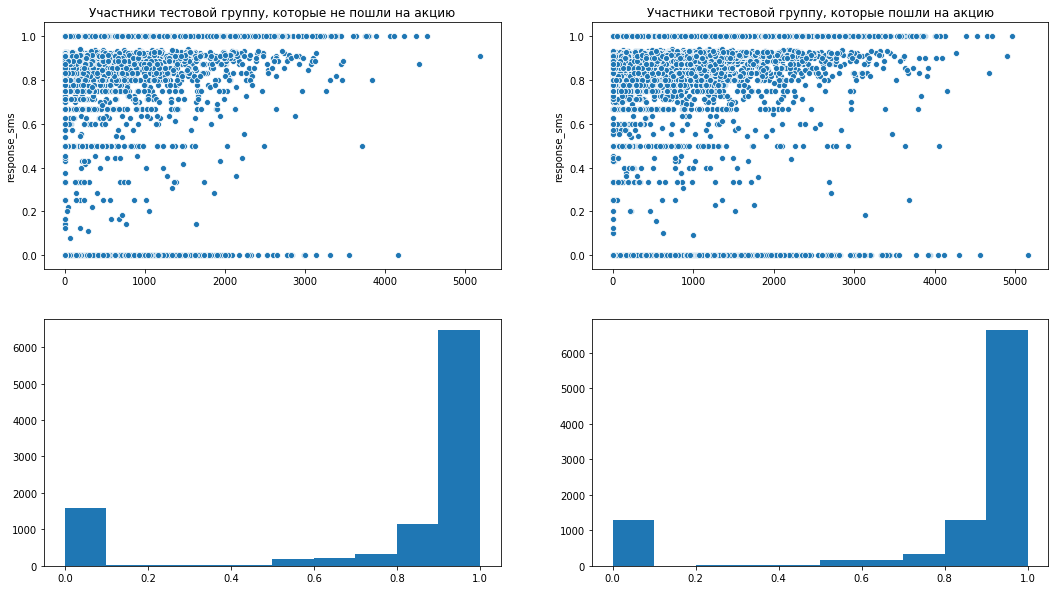

In [29]:
# Let's take random sample in each subgroup with same size
sample_size = 10000

fig, ax = plt.subplots(2, 2, figsize=(18, 10))
sales_sum = ['sale_sum_3m_g{}'.format(i) for i in [24, 26, 32, 33]]

plt.subplot(221)
sample = stubborn.loc[np.random.choice(stubborn.index, sample_size, replace=False)]
sns.scatterplot(sample[sales_sum].sum(axis=1), sample['response_sms'])
plt.title('Участники тестовой группы, которые не пошли на акцию')

plt.subplot(223)
plt.hist(sample['response_sms'])

plt.subplot(222)
sample = active.loc[np.random.choice(active.index, sample_size, replace=False)]
sns.scatterplot(sample[sales_sum].sum(axis=1), sample['response_sms'])
plt.title('Участники тестовой группы, которые пошли на акцию')

plt.subplot(224)
plt.hist(sample['response_sms'])

plt.show()

В данных видна определенная дискретность, видны линии, которые позволяют предположить, сколько было смс-рассылок

In [8]:
from scipy.linalg import svd

In [ ]:
sample = data[data['group'] == 1]
sample = sample[sample['response_att']==1].fillna(0).drop('response_att', axis=1)
sample = (sample - data.drop('response_att', axis=1).mean())
U, s, Vh = svd(sample, full_matrices=False)
feature1 = (U @ np.diag(s))[:, 0]
feature2 = (U @ np.diag(s))[:, 1]
sns.scatterplot(feature1, feature2)

sample = data[data['group'] == 1]
sample = sample[sample['response_att']==0].fillna(0).drop('response_att', axis=1)
sample = (sample - data.drop('response_att', axis=1).mean())
U, s, Vh = svd(sample, full_matrices=False)
feature1 = (U @ np.diag(s))[:, 0]
feature2 = (U @ np.diag(s))[:, 1]
sns.scatterplot(feature1, feature2)

plt.show()